# Bernoulli Gambler Bandit

## Beta Distribution

In [0]:
%matplotlib inline

In [0]:
import matplotlib.pyplot as plt
from math import factorial
from scipy.stats import beta
from scipy.special import binom
from scipy.special import beta as beta_func
from scipy.special import betainc as reg_inc_beta_func
from scipy.special import gamma as gamma_func
from scipy.integrate import quad as integral
from scipy.integrate import fixed_quad as integralf
from scipy.integrate import quadrature as integralq
from scipy.integrate import romberg as integralr
from scipy.integrate import trapz as integralt
from scipy.integrate import simps as integrals
from mpmath import hyp2f1 as hypergeo_func
import numpy as np

Calculate a few first moments:

In [0]:
#suppose a grid of k_x x k_y machines
k_x = 3
k_y = 3

#then k slot machines
k = k_x * k_y

#samples
arr_p_size = 100
arr_s_size = 2000

#arr_p = np.linspace(beta.ppf(0, a, b), beta.ppf(1, a, b), num_points)
arr_p = np.linspace(0, 1, arr_p_size)
arr_q = 1 - arr_p

# n is the nuber of trials for each slot
arr_n = np.array(
    [[0, 4, 50],
     [1, 5, 50],
     [1, 5, 50]])

# x is the nuber of successes
arr_x = np.array(
    [[0, 2, 25],
     [0, 1, 10],
     [1, 4, 40]])

# y is the nuber of fails
arr_y = arr_n - arr_x

#prior = [1, 1]

#alpha and beta parameters considering prior
arr_alpha = arr_x+1
arr_beta = arr_y+1

#------------------------------------------------------------------------------
#incomplete beta function
inc_beta_func = lambda alpha, beta, p_sup : reg_inc_beta_func(alpha, beta, p_sup) * beta_func(alpha, beta)

#------------------------------------------------------------------------------
#probability of ruin
ruin_func = lambda p, q, b : (q/p)**b if p>0.5 else 1

#ruin_cumulative_func = lambda b, p_sup : integral(lambda p : ruin_func(p, 1-p, b), 0, p_sup)
ruin_cumu_func = lambda b, p_sup : 0.5 + integral(lambda p, b : (1-p)**b/p**b, 0.5, p_sup, b)[0] if p_sup>0.5 else p_sup
#ruin_cumu_func = lambda b, p_sup : inc_beta_func(1-b, 1+b, p_sup) if p_sup>0.5 else p_sup
#ruin_cumu_func = lambda b, p_sup : (1/p_sup)**b * p_sup**b * inc_beta_func(1-b, 1+b, p_sup) if p_sup>0.5 else p_sup
#ruin_cumu_func = lambda b, p_sup : -1 * ((1/p_sup)**(b-1) * hypergeo_func(1-b, -b, 2-b, p_sup)) / (b-1) if p_sup>0.5 else p_sup

#------------------------------------------------------------------------------
#eta funcion (normalizing constant for beta pdf with uniform prior)

eta_func_using_beta = lambda alpha, beta : 1 / beta_func(alpha, beta)
eta_func_using_gamma = lambda alpha, beta : gamma_func(alpha+beta) / (gamma_func(alpha) * gamma_func(beta))
eta_func_using_factorial = lambda x, y : factorial(x+y+1) / (factorial(x) * factorial(y))
eta_func_using_binom = lambda x, y : (x+y+1) * binom(x+y, x)

def eta_func(x=None, y=None, n=None, alpha=None, beta=None, method='beta'):

  if ((x != None) and (y != None)):
    n = x + y
    alpha = x+1
    beta = y+1
  elif ((x != None) and (n != None)):
    y = n - x
    alpha = x+1
    beta = y+1
  elif ((y != None) and (n != None)):
    x = n - y
    alpha = x+1
    beta = y+1
  elif ((alpha != None) and (beta != None)):
    x = alpha-1
    y = beta-1
    n = x+y
  else:
    return 0

  if (method=='factorial'):
    return factorial(n+1) / (factorial(x) * factorial(y))
  elif (method=='gamma'):
    return gamma_func(alpha+beta) / (gamma_func(alpha) * gamma_func(beta))
  elif (method=='binom'):
    return (n+1) * binom(n, x)
  else: #(method=='beta'):
    return 1 / beta_func(alpha, beta)

#------------------------------------------------------------------------------

#beta pdf using uniform prior
beta_pdf_func = lambda x, y, p, q : eta_func(x, y) * p**x * q**y

#beta cdf using uniform prior
beta_cdf_func = lambda x, y, p_sup : reg_inc_beta_func(x+1, y+1, p_sup)
beta_cdf_func_using_integral = lambda x, y, p_sup : integral(lambda p: beta_pdf_func(x, y, p), 0, p_sup)[0]

#estimated probability of ruin
#ruin_est_func = lambda n, x, y, p, q, b : ruin_func(p, q, b) * beta_pdf_func(x, y, p, q)
ruin_est_func = lambda n, x, y, p, q, b : (1 / beta_func(x+1, y+1)) * p**x * q**y * (q/p)**b  if  (p > 0.5)  else  (1 / beta_func(x+1, y+1)) * p**x * q**y

ruin_est_func_for_cumu = lambda p, x, y, b : (1 / beta_func(x+1, y+1)) * p**x * (1-p)**y * ((1-p)/p)**b  if  (p > 0.5)  else  (1 / beta_func(x+1, y+1)) * p**x * (1-p)**y
ruin_cumu_est_func = lambda p_sup, x, y, b : integral(ruin_est_func_for_cumu, 0, p_sup, (x, y, b))[0]
ruin_total_est_func_x = lambda x, y, b : ruin_cumu_est_func(1, x, y, b)

#ruin_est_func_for_total = lambda p, x, y, b : (1 / beta_func(x+1, y+1)) * p**x * (1-p)**y * ((1-p)/p)**b
#ruin_est_func_for_total = lambda p, x, y, b : ((1-p)/p)**b * beta.pdf(p, x+1, y+1)
#ruin_total_est_func = lambda x, y, b : beta.cdf(0.5, x+1, y+1) + integral(ruin_est_func_for_total, 0.5, 1.0, (x, y, b))[0]
ruin_total_est_func = lambda x, y, b : beta.cdf(0.5, x+1, y+1) + integral(lambda p, x, y, b : ((1-p)/p)**b * beta.pdf(p, x+1, y+1), 0.5, 1.0, (x, y, b))[0]
ruin_total_est_func_f = lambda x, y, b : beta.cdf(0.5, x+1, y+1) + integralf(lambda p, x, y, b : ((1-p)/p)**b * beta.pdf(p, x+1, y+1), 0.5, 1.0, (x, y, b))[0]
ruin_total_est_func_q = lambda x, y, b : beta.cdf(0.5, x+1, y+1) + integralq(lambda p, x, y, b : ((1-p)/p)**b * beta.pdf(p, x+1, y+1), 0.5, 1.0, (x, y, b))[0]
ruin_total_est_func_r = lambda x, y, b : beta.cdf(0.5, x+1, y+1) + integralr(lambda p, x, y, b : ((1-p)/p)**b * beta.pdf(p, x+1, y+1), 0.5, 1.0, (x, y, b))[0]

#------------------------------------------------------------------------------

#budget
b = 5

#ruin_prob given budget
ruin_prob = np.zeros((arr_p_size))
ruin_cumu = np.zeros((arr_p_size))
for p in range(arr_p_size):
    ruin_prob[p] = ruin_func(arr_p[p], arr_q[p], b)
    ruin_cumu[p] = ruin_cumu_func(b, arr_p[p])
#ruin_prob = np.array([ruin_func(arr_p[p], arr_q[p], b) for p in range(arr_p_size)])

#prepare the probability density function (pdf):
#prepare the cumulative probability function (cdf):
#calculate beta moments
#generate random numbers drawn from the distribution:
pdf = np.zeros((k_x, k_y, arr_p_size))
#pdf_hand = np.zeros((k_x, k_y, arr_p_size))
cdf = np.zeros((k_x, k_y, arr_p_size))
#cdf_hand = np.zeros((k_x, k_y, arr_p_size))
mean = np.zeros((k_x, k_y))
peak = np.zeros((k_x, k_y))
nvsk = np.zeros((k_x, k_y, 4))
samples = np.zeros((k_x, k_y, arr_s_size))
ruin_prob_est = np.zeros((k_x, k_y, arr_p_size))
#ruin_prob_est_hand = np.zeros((k_x, k_y, arr_p_size))
ruin_est_cumu = np.zeros((k_x, k_y, arr_p_size))

for i in range(k_x):
    for j in range(k_y):
        pdf[i][j] = beta.pdf(arr_p, arr_alpha[i][j], arr_beta[i][j])  
        cdf[i][j] = beta.cdf(arr_p, arr_alpha[i][j], arr_beta[i][j])  
        #nvsk[i][j] = beta.stats(arr_alpha[i][j], arr_beta[i][j], moments='mvsk')  #mean, var, skew, kurt
        mean[i][j] = beta.mean(arr_alpha[i][j], arr_beta[i][j])
        peak[i][j] = arr_p[np.argmax(pdf[i][j])]
        #samples[i][j] = beta.rvs(arr_alpha[i][j], arr_beta[i][j], size=arr_s_size)
        ruin_prob_est[i][j] = pdf[i][j] * ruin_prob
        for p in range(arr_p_size):
            pdf_hand[i][j][p] = beta_pdf_func(arr_x[i][j], arr_y[i][j], arr_p[p], arr_q[p])
            cdf_hand[i][j][p] = beta_cdf_func(arr_x[i][j], arr_y[i][j], arr_p[p])
            #ruin_prob_est_hand[i][j][p] = ruin_est_func(arr_n[i][j], arr_x[i][j], arr_y[i][j], arr_p[p], arr_q[p], b)
            ruin_est_cumu[i][j][p] = ruin_cumu_est_func(arr_p[p], arr_x[i][j], arr_y[i][j], b)


Show


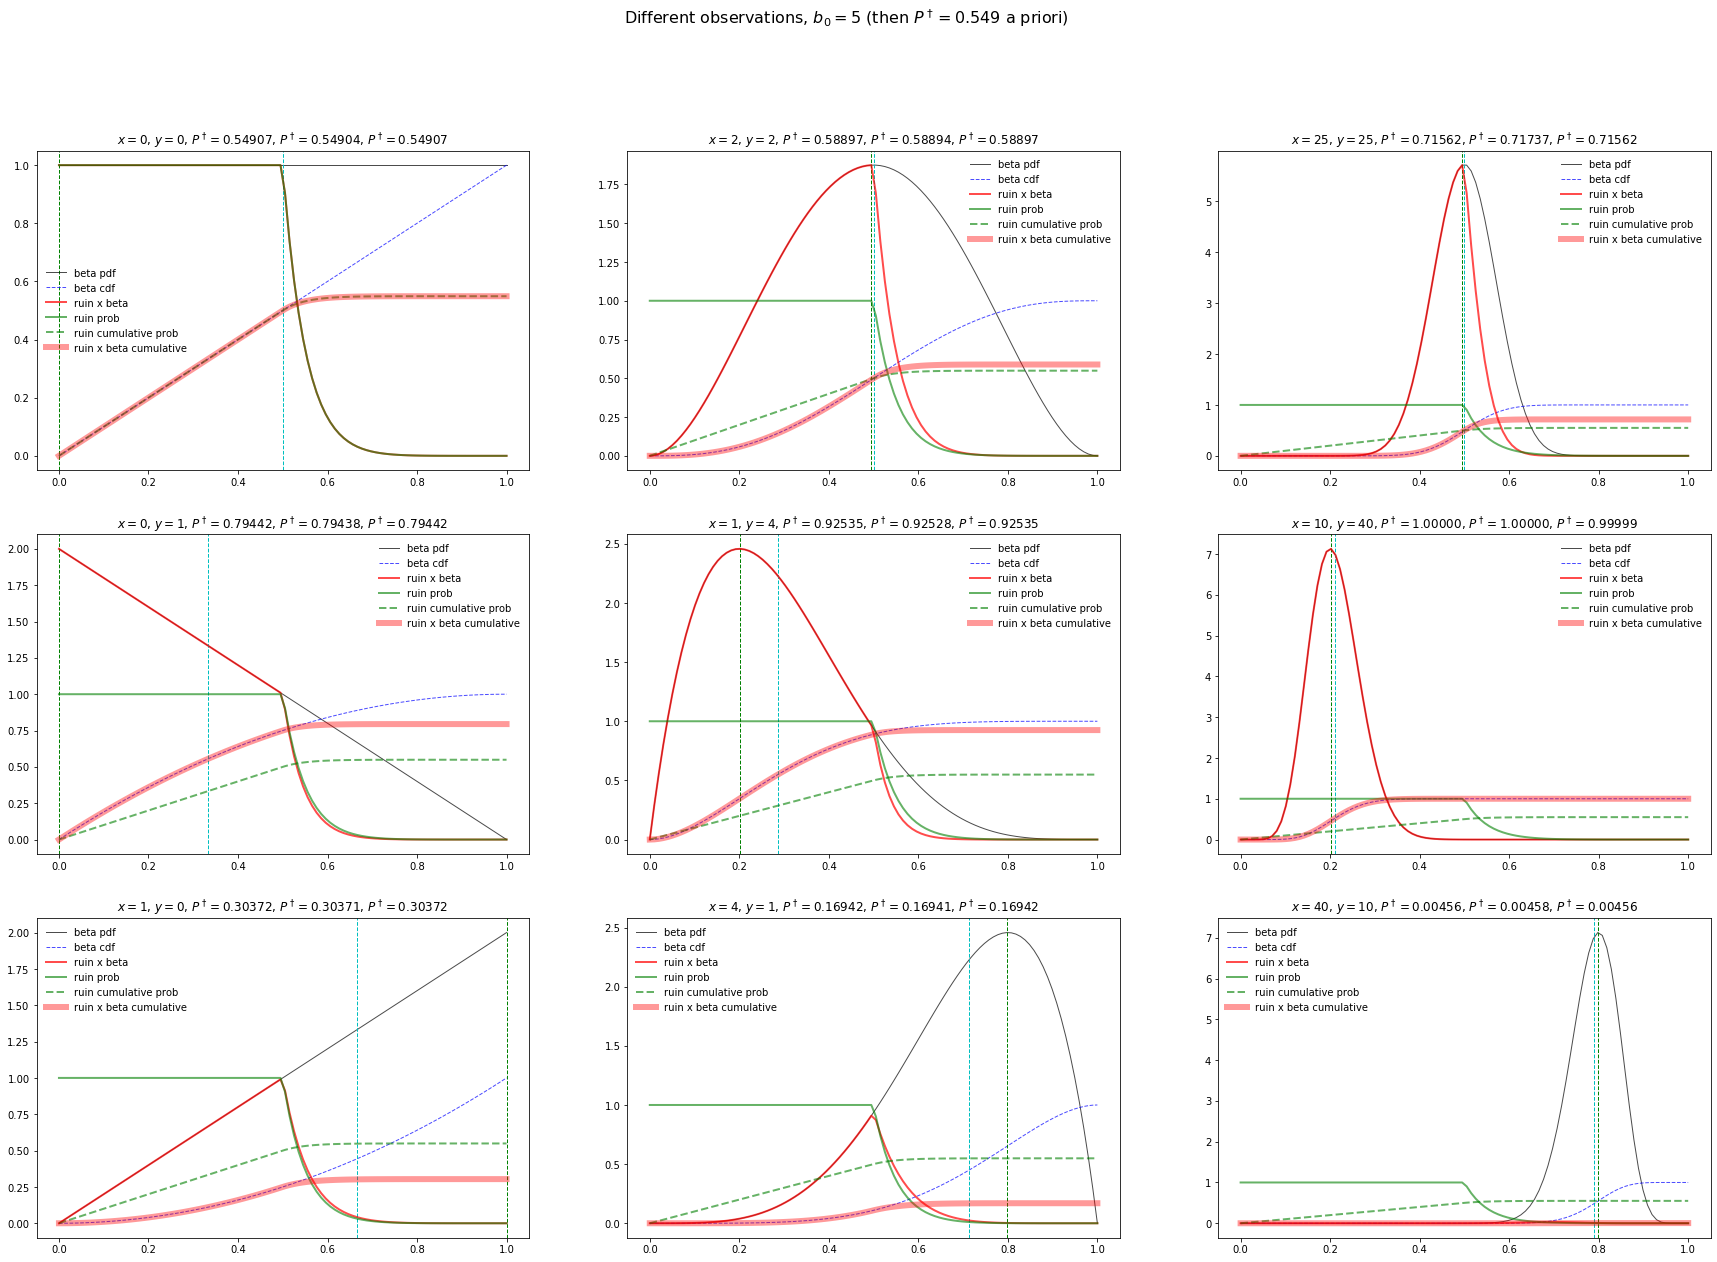

In [48]:
fig, ax = plt.subplots(k_x, k_y, figsize=(30, 20))

fig.suptitle(f'Different observations, $b_0={b}$ (then $P^\\dagger={ruin_cumu_func(b, 1):.3f}$ a priori)' , fontsize=16)

for i in range(k_x):
    for j in range(k_y):
        #ax[i,j].set_title(f'$x={arr_x[i][j]}$, $y={arr_y[i][j]}$, $P^\\dagger={ruin_total_est_func(arr_x[i][j], arr_y[i][j], b):.5f}$')
        ax[i,j].set_title(f'$x={arr_x[i][j]}$, $y={arr_y[i][j]}$, $P^\\dagger={ruin_total_est_func(arr_x[i][j], arr_y[i][j], b):.5f}$, $P^\\dagger={ruin_total_est_func_f(arr_x[i][j], arr_y[i][j], b):.5f}$, $P^\\dagger={ruin_total_est_func_q(arr_x[i][j], arr_y[i][j], b):.5f}$')
        #ax[i,j].set_xlabel('p')
        #ax[i,j].set_ylabel('v')
        #ax[i,j].hist(samples[i][j], density=True, histtype='stepfilled', alpha=0.2)
        ax[i,j].plot(arr_p, pdf[i][j] , 'k-', lw=1, alpha=0.7, label='beta pdf')
        #ax[i,j].plot(arr_p, pdf_hand[i][j] , 'ko', lw=3, alpha=0.2, label='beta pdf hand')
        ax[i,j].plot(arr_p, cdf[i][j] , 'b--', lw=1, alpha=0.7, label='beta cdf')
        #ax[i,j].plot(arr_p, cdf_hand[i][j] , 'bo', lw=3, alpha=0.2, label='beta cdf hand')
        ax[i,j].axvline(x=mean[i][j], color='c', lw=1, linestyle='--')
        ax[i,j].axvline(x=peak[i][j], color='g', lw=1, linestyle='--')
        ax[i,j].plot(arr_p, ruin_prob_est[i][j] , 'r-', lw=2, alpha=0.7, label='ruin x beta')
        #ax[i,j].plot(arr_p, ruin_prob_est_hand[i][j] , 'ro', lw=3, alpha=0.2, label='ruin x beta hand')
        ax[i,j].plot(arr_p, ruin_prob , 'g-', lw=2, alpha=0.6, label='ruin prob')
        ax[i,j].plot(arr_p, ruin_cumu , 'g--', lw=2, alpha=0.6, label='ruin cumulative prob')
        ax[i,j].plot(arr_p, ruin_est_cumu[i][j] , 'r-', lw=6, alpha=0.4, label='ruin x beta cumulative')
        ax[i,j].legend(loc='best', frameon=False)
        
plt.show()


Probability of Ruin

In [0]:
#b = 1
#ruin_cumu = np.zeros((arr_p_size))
#for p in range(arr_p_size):
#  ruin_cumu[p] = ruin_cumu_func(b, arr_p[p])

arr_b_size = 500
arr_b = range(arr_b_size)
ruin_prob = np.zeros((arr_p_size, arr_b_size))
ruin_cumu = np.zeros((arr_p_size, arr_b_size))
for p in range(arr_p_size):
    for b in range(arr_b_size):
        ruin_prob[p][b] = ruin_func(arr_p[p], arr_q[p], arr_b[b])
        ruin_cumu[p][b] = ruin_cumu_func(arr_b[b], arr_p[p])


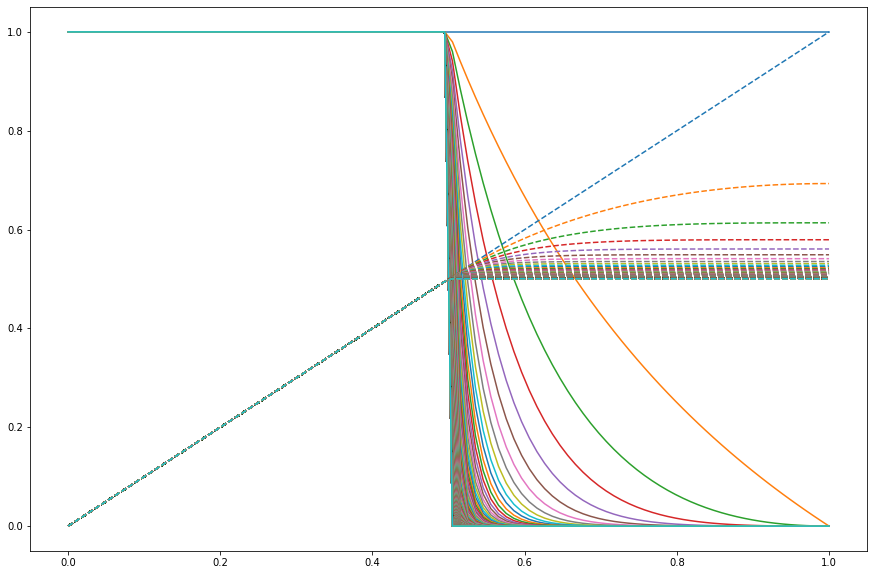

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

plt.plot(arr_p, ruin_prob , label='ruin probabilities')
plt.plot(arr_p, ruin_cumu , linestyle='--', label='ruin cumulative probabilities')
      
plt.show()

#print(arr_b)
